In [1]:
# Trying ridge class from scratch again.
# Import libraries.
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import math

In [9]:
# Read data.
data = pd.read_csv('data2016.csv')

data['538_2016_avg'] = data['538_2016_avg'] /100

data.head(1)

,state_po,D12,D16,bach2016,bach_white2016,538_2016_avg
0,AL,0.387838,0.356259,0.247,0.273,0.33454


In [10]:
y_ = data.pop('D16')
states = data.pop('state_po')

data = data - data.mean()

y_ = y_ - y_.mean()

In [21]:
class ridge_reg:

    def __init__(self, X, y, K=10, inc=1, cross_valid=True):
        # Inputs.
        self.X = X      # Predictors for the regression.
        self.y = y      # Target for the regression.
        self.p = X.shape[1] # Predictors.

        # Settings
        self.K = K      # Number of folds to use in K-fold CV.
        self.inc = inc  # Increments for Newton-Raphson method.
        self.cross_valid = cross_valid  # Should we use cross validation.

        # Results.
        self.result = None


    # Convert result into dataframe.
    def result_df(self):
        temp_df = pd.DataFrame(self.result)
        temp_df = temp_df.explode(['edfs', 'rss'])

        temp_df['edfs'] = pd.to_numeric(temp_df['edfs'])
        temp_df['rss'] = pd.to_numeric(temp_df['rss'])

        eDFS = temp_df['edfs'].unique()
        cv_avgs = temp_df.groupby('edfs')['rss'].mean().reset_index(drop=True)

        result_df = pd.DataFrame({
            'edfs': eDFS, 'cv_err': cv_avgs
        })

        std_errs = self.get_std_errs(temp_df, result_df)

        result_df['cv_std_err'] = std_errs

        self.result = result_df


    # Make standard errors from CV_err sample mean.
    def get_std_errs(self, samples, avgs):
        storage_std_errs = []
        for i in range(self.p + 1):
            sample_mask = samples['edfs'] == i
            avgs_mask = avgs['edfs'] == i

            samples_ = samples[sample_mask]['rss']
            n = len(samples_)
            sample_avg = float(avgs[avgs_mask]['cv_err'][i])

            sample_std_dev = math.sqrt(sum((samples_ - sample_avg)**2) / (n-1))
            #std_err = sample_std_dev / math.sqrt(n)

            storage_std_errs.append(sample_std_dev)
        return storage_std_errs



    # Get CV error for edf = 0, the constant model.
    def const_model_result(self, folds):
        rss_, no_, edfs = [], np.nan, np.zeros(self.K)
        for i in range(self.K):
            fold_mask = folds != i
            fold_size = sum(fold_mask == True)

            y_train = self.y[fold_mask]
            y_train_avg = y_train.mean()

            rss = self.rss(y_train, y_train_avg, n=fold_size)
            rss_.append(rss)
        const_model = {'fold_no': no_, 'edfs': edfs, 'rss': rss_}
        return const_model


    # Newton-Raphson for getting EDFs and penalty hyperparameters.
    def newtons_method(self, X_train):
        dfs_no = self.p
        dfs = np.arange(self.inc, dfs_no + self.inc, self.inc)

        U, SIGMA, V = scipy.linalg.svd(X_train, full_matrices=False)
        d = SIGMA**2

        newt_thresh = 1e-3

        reg_params = []
        for df in dfs:
            param_j = 0
            param_j_next = 1e6

            difference = param_j_next - param_j
            while abs(difference) > newt_thresh:
                h_paramj = sum((d)/(d + param_j)) - df
                h_prime_paramj = sum((d)/((d + param_j)**2))
                param_j_next = param_j + (h_paramj) / (h_prime_paramj)
                difference = param_j_next - param_j
                param_j = param_j_next
            reg_params.append(param_j_next)

        return reg_params, dfs


    # Calculate ridge regression coefficient estimates.
    def get_betas(self, X, y, penalty):
        X, y = X.to_numpy(), y.to_numpy()
        I = np.identity(self.p)

        b = np.linalg.inv(X.T @ X + penalty * I) @ X.T @ y
        return b


    # Function to get predictions (y_hat)
    def predict(self, X, beta):
        X = X.to_numpy()
        return X @ beta


    # Function to get CV rss.
    def rss(self, y_tru, y_hat, n):
        return ((y_tru - y_hat)**2).sum() / n


    # Function to get K-folds of data.
    def K_folds(self):
        K, n = self.K, len(self.X)

        idxs_X = np.arange(n)
        idxs_fold = np.zeros(n)

        quo, remain = divmod(n, K)
        fold_size = [quo for _ in range(K)]
        for i in range(remain):
          fold_size[i] += 1

        for j, fold_size in enumerate(fold_size):
          curr_fold = np.random.choice(idxs_X, fold_size, replace=False)
          idxs_fold[curr_fold] = j

          idxs_X = sorted(list(set(idxs_X) - set(curr_fold)))

        return idxs_fold


    # Function to fit model, when we need to use cross-validation.
    def fit_with_cv(self):

        result = []

        K_fold_idxs = self.K_folds()

        const_models = self.const_model_result(K_fold_idxs)
        result.append(const_models)

        # Iterate through folds.
        for i in range(self.K):
            fold_mask = K_fold_idxs != i
            fold_size = sum(fold_mask == True)

            X_train = self.X[fold_mask]
            y_train = self.y[fold_mask]

            penalties, dfs = self.newtons_method(X_train)

            _edfs, _rss = [], []
            for penalty, df in zip(penalties, dfs):
                b = self.get_betas(X_train, y_train, penalty)
                y_hat = self.predict(X_train, b)
                rss = self.rss(y_train, y_hat, n=fold_size)
                _edfs.append(df)
                _rss.append(rss)
            fold_result = {
                'fold_no': i, 'edfs': _edfs, 'rss': _rss
            }
            result.append(fold_result)
        self.result = result
        self.result_df()

    
    # Fit without cross-validation, to examine estimators.
    def fit_no_cv(self):
        penalties, dfs = self.newtons_method(self.X)

        ridge_betas = []
        for l_ in penalties:
            betas = self.get_betas(self.X, self.y, l_)
            ridge_betas.append(betas)
        self.result = ridge_betas    

    # Main fit function.
    def fit(self):
        if self.cross_valid == True:
            self.fit_with_cv()
        elif self.cross_valid == False:
            self.fit_no_cv()

In [27]:
model = ridge_reg(data, y_, K=5)
model.fit()

In [28]:
res = model.result
print(res)

   edfs    cv_err  cv_std_err
0   0.0  0.011684    0.001002
1   1.0  0.001618    0.000155
2   2.0  0.000489    0.000105
3   3.0  0.000356    0.000096
4   4.0  0.000315    0.000092


In [29]:
# Find the best model.
best_mod_idx = res.cv_err.idxmin()
best_mask = res.index == best_mod_idx
res['best'] = np.where(best_mask, 1, 0)


# Find model within one standard deviation of the best model.
res['within_one'] = (res['cv_err'] + res['cv_std_err'])
res['within_'] = np.where(res.cv_err <= res.within_one[best_mod_idx], 1, 0)

optimal_model_idx = res['within_'].idxmax()
optimal_mask = res.index == optimal_model_idx

# Coordinates for plotting.
y_coord = res[best_mask].within_one
x_coord = res[optimal_mask].edfs


<function axes at 0x00000206E1391B20>


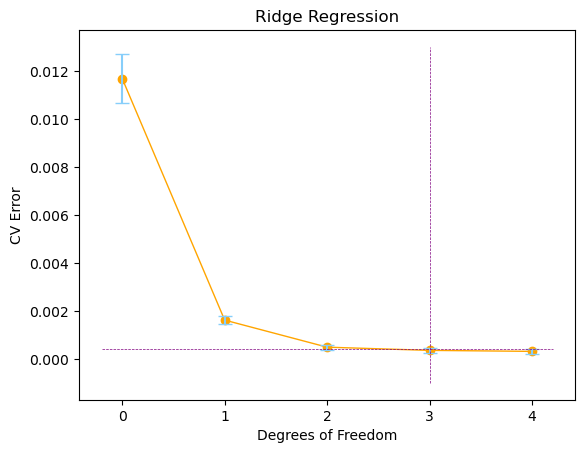

In [37]:
plt.plot(res['edfs'], res['cv_err'], 'o-', color='orange', lw=1)
plt.errorbar(res['edfs'], res['cv_err'], yerr=res['cv_std_err'], ecolor='lightskyblue', ls='None', capsize=5)
nums = plt.axes
print(nums)
plt.plot([-.2, 4.2], [y_coord, y_coord], '--', color='purple', lw=0.5)
plt.plot([x_coord, x_coord],[-0.001,0.013], '--', color='purple', lw=0.5)


plt.title("Ridge Regression")
plt.xlabel('Degrees of Freedom')
plt.ylabel('CV Error')

plt.show()

In [50]:
model_2 = ridge_reg(data, y_, inc=0.5, cross_valid=False)
model_2.fit()
ridge_betas = model_2.result

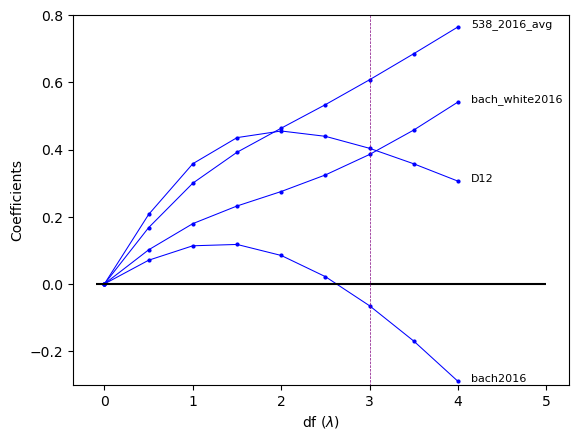

In [51]:
const_model = np.zeros(4)
ridge_betas.insert(0, const_model)

dfs = np.arange(0, data.shape[1] + 0.5, 0.5)

plt.plot(dfs, ridge_betas, 'o-',markersize=2, c='blue', lw=0.75)

plt.ylabel('Coefficients')
plt.xlabel('df ($\lambda$)')

plt.hlines(y=0, xmin=-0.1, xmax=5, colors='black')
plt.plot([x_coord, x_coord],[-1,1], '--', color='purple', lw=0.5)

plt.ylim([-0.3, 0.8])

for x, y, s in zip(np.ones(4)*(4+0.15), ridge_betas[-1], data.columns):
    plt.text(x, y, s, color='0', fontsize=8)
plt.show()